For better look in jupyternotebook. Please execute the following cell.

In [ ]:
%%HTML
<style>
    body {
        --vscode-font-family: "LXGW WenKai";
        line-height: 2; Í
    }
</style>

In [ ]:
import os 
import findspark 
findspark.init()

# for sql
from pyspark.sql import SparkSession 
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, sum,avg,max,count
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, DoubleType, LongType, TimestampType

# for time 
import datetime as dt
import psutil

# for plot
import matplotlib.pyplot as plt
import squarify





In [ ]:
# Definieren des Schemas basierend auf der Struktur
schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])

# RFM-Segmentation

This section aims at solving a big data use case demonstrated by the RFM-Segmentation.
A short introduction to RFM-Analysis and the RFM-Segmentation

### RFM Analysis
RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries.

RFM stands for the three dimensions:

* Recency – How recently did the customer purchase?
* Frequency – How often do they purchase?
* Monetary Value – How much do they spend?

source: [wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research))

so we will calculate the 3 attributes Recency, Frequency, and Monetary

### RFM Segmentation

RFM segmentation is a useful tool for identifying groups of clients who should be given extra attention. RFM segmentation enables marketers to target specific groups of customers with communications that are far more relevant to their unique behaviors, resulting in improved response rates, enhanced loyalty, and increased customer lifetime value. RFM segmentation is a method for segmenting data, just like other approaches.

The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.


The Code is divided into multiple phases:

1. Spark Session Initialization

    Initializes a SparkSession with a specified master node and application name "rfm-segmentation".
    This is the starting point for any Spark application and is used for configuring Spark's settings.

2. Data Loading and Initial Processing

    Reads an ecommerce CSV file into a Spark DataFrame with a predefined schema and prints the schema to confirm the data structure.
    It filters the data to include only purchase events and caches the result for efficient access during further transformations.

3. Data Aggregation

    Groups the filtered purchase data by "user_session" and aggregates it to compute the maximum event time, unique user IDs, count of sessions, and total money spent per session.
    This aggregated data is then used to derive insights on user behavior within the ecommerce platform.

4. Data Preparation for RFM Analysis

    This step prepares the data for RFM segmentation by determining how recently and frequently each user has made purchases and how much they have spent.

5. RFM Segmentation Calculation

    Performs RFM analysis by grouping data on a user level and calculating Recency, Frequency, and Monetary values.
    Determines quantiles for Recency, Frequency, and Monetary to classify users into different segments based on their behavior.

6. RFM Score Assignment

    Assigns RFM quartiles and scores to each user based on the calculated quantiles. This involves categorizing users into segments such as "Lost", "Hibernating", etc., based on their RFM scores.
    The RFM score is a composite score given to each customer to represent their overall value to the business.

7. RFM Labeling and Segmentation Summary

    Further refines the RFM segments by assigning descriptive labels based on the RFM score.
    Aggregates the final RFM results to calculate average Recency, Frequency, and Monetary values for each segment, along with the size of each segment.

8. Visualization

    The final part of the code involves creating a visualization of the RFM segments using a squarify plot to represent the size of each segment visually. This helpf for understanding the distribution of users across different RFM segments.

In [ ]:
# for Recency
def R(x, q1, q2, q3):
    if x <= q1:
        return 1
    elif x <= q2:
        return 2
    elif x <= q3:
        return 3
    else:
        return 4

# for Frequency und Monetary
def FM(x, q1, q2, q3):
    if x <= q1:
        return 4
    elif x <= q2:
        return 3
    elif x <= q3:
        return 2
    else:
        return 1

def run_rfm_segmentation(mastername, dateiname, schema):
    
    memory = psutil.virtual_memory()
    print(f"Memory Usage: {memory.percent}%")

    
    disk_io_start = psutil.disk_io_counters()
    
            
#---------------- Phase 1

    spark = SparkSession.builder \
        .master(mastername) \
        .appName("rfm-segmentation") \
        .getOrCreate()
        
#---------------- Phase 2
    
    ecommerce = spark.read.csv(dateiname, schema=schema, header=True)

    print(ecommerce.rdd.getNumPartitions())
    only_purchases = ecommerce.filter(col("event_type") == 'purchase').cache()

        
#---------------- Phase 3

    aggregated_data = only_purchases.groupBy("user_session") \
        .agg(
            F.max("event_time").alias("Date_order"),
            F.collect_set("user_id").alias("user_id"),  
            F.count("user_session").alias("Quantity"),
            F.sum("price").alias("money_spent")
        )

         
#---------------- Phase 4  
    
    study_date = dt.datetime(2019, 12, 1)

    
    data = aggregated_data.withColumn("Date_order", F.col("Date_order").cast(DateType()))

    
    data = data.withColumn("last_purchase", F.datediff(F.lit(study_date), "Date_order"))

        


    RFM_result = data.groupBy("user_id") \
        .agg(
            F.min("last_purchase").alias("Recency"),
            F.count("user_id").alias("Frequency"),
            F.sum("money_spent").alias("Monetary")
        )

        
#---------------- Phase 5
 
    quantile_probs = [0.25, 0.5, 0.75]
    rel_error = 0.01  

    
    recency_quantiles = RFM_result.stat.approxQuantile("Recency", quantile_probs, rel_error)
    frequency_quantiles = RFM_result.stat.approxQuantile("Frequency", quantile_probs, rel_error)
    monetary_quantiles = RFM_result.stat.approxQuantile("Monetary", quantile_probs, rel_error)

    
    quartiles = {
        'Recency': dict(zip(quantile_probs, recency_quantiles)),
        'Frequency': dict(zip(quantile_probs, frequency_quantiles)),
        'Monetary': dict(zip(quantile_probs, monetary_quantiles))
    }

    #
    recency_quartiles = [quartiles['Recency'][0.25], quartiles['Recency'][0.50], quartiles['Recency'][0.75]]
    frequency_quartiles = [quartiles['Frequency'][0.25], quartiles['Frequency'][0.50], quartiles['Frequency'][0.75]]
    monetary_quartiles = [quartiles['Monetary'][0.25], quartiles['Monetary'][0.50], quartiles['Monetary'][0.75]]

        
#---------------- Phase 6

    RFM_result = RFM_result.withColumn('R_Quartile', 
        when(col('Recency') <= recency_quartiles[0], 1)
        .when(col('Recency') <= recency_quartiles[1], 2)
        .when(col('Recency') <= recency_quartiles[2], 3)
        .otherwise(4))

    RFM_result = RFM_result.withColumn('F_Quartile', 
        when(col('Frequency') <= frequency_quartiles[0], 4)
        .when(col('Frequency') <= frequency_quartiles[1], 3)
        .when(col('Frequency') <= frequency_quartiles[2], 2)
        .otherwise(1))

    RFM_result = RFM_result.withColumn('M_Quartile', 
        when(col('Monetary') <= monetary_quartiles[0], 4)
        .when(col('Monetary') <= monetary_quartiles[1], 3)
        .when(col('Monetary') <= monetary_quartiles[2], 2)
        .otherwise(1))


    RFM_result = RFM_result.withColumn('RFM_segmentation', 
        col('R_Quartile').cast(StringType()) + 
        col('F_Quartile').cast(StringType()) + 
        col('M_Quartile').cast(StringType()))

    RFM_result = RFM_result.withColumn('RFM_score', 
        col('R_Quartile') + 
        col('F_Quartile') + 
        col('M_Quartile'))

        
#---------------- Phase 7

    RFM_result = RFM_result.withColumn('RFM_label', 
        when(col('RFM_score') >= 10, 'Lost')
        .when(col('RFM_score') >= 9, 'Hibernating')
        .when(col('RFM_score') >= 8, 'Can’t Lose Them')
        .when(col('RFM_score') >= 7, 'About To Sleep')
        .when(col('RFM_score') >= 6, 'Promising')
        .when(col('RFM_score') >= 5, 'Potential Loyalist')
        .when(col('RFM_score') >= 4, 'Loyal Customers')
        .otherwise('Champions'))

 
    RFM_desc = RFM_result.groupBy('RFM_label').agg(
        F.mean('Recency').alias('Average_Recency'),
        F.mean('Frequency').alias('Average_Frequency'),
        F.mean('Monetary').alias('Average_Monetary'),
        F.count('RFM_label').alias('Segment_Size')
    )


    RFM_desc = RFM_desc.select(
        'RFM_label',
        F.round('Average_Recency', 1).alias('Average_Recency'),
        F.round('Average_Frequency', 1).alias('Average_Frequency'),
        F.round('Average_Monetary', 1).alias('Average_Monetary'),
        'Segment_Size'
    )


    RFM_desc.show()


    sizes = RFM_desc.select("Segment_Size").rdd.flatMap(lambda x: x).collect()
    labels = RFM_desc.select("RFM_label").rdd.flatMap(lambda x: x).collect()

        
#---------------- Phase 8

    #fig = plt.gcf()
    #ax = fig.add_subplot()
    #fig.set_size_inches(16, 9)


    #squarify.plot(sizes=sizes, label=labels, alpha=.6)
    #plt.title("RFM Segments", fontsize=18, fontweight="bold")
    #plt.axis('off')
    
    disk_io_end = psutil.disk_io_counters()

    read_bytes = disk_io_end.read_bytes - disk_io_start.read_bytes
    write_bytes = disk_io_end.write_bytes - disk_io_start.write_bytes

    print(f"Read: {read_bytes / 1024 / 1024:.2f} MB, Write: {write_bytes / 1024 / 1024:.2f} MB")


# Data Scaling (Cluster)

In this section we want to provide an overview for scaling our spark application based on a local standalone cluster setup

Therefore we compare the total time of the application and the important metrics of the longest job of the aplication based on different cluster configurations.

**To accurately setup the test invorement for the cluster, use the terminal to create the master node and the worker node(s)
The following code has to be excecuted in the bin folder of your spark installation.**

master node:
spark-class org.apache.spark.deploy.master.Master

worker node:
spark-class org.apache.spark.deploy.worker.Worker spark://<masternode-ip>:<masternode-port>

*The base configuration for worker nodes is 15.0 GiB (1024.0 MiB Used) of RAM and 10 Cores .
The worker can be configured by using --cores x for the number of cores and --memory x for the associated RAM.*

e.g.

./spark-class org.apache.spark.deploy.worker.Worker \
    --cores 5 \
    spark://100.119.9.7:7077

./spark-class org.apache.spark.deploy.worker.Worker \
    --memory 512m \
    spark://100.119.9.7:7077

After creating the cluster, change the "spark://<masternode-ip>:<masternode-port>" of the cluster the test according to your cluster.

The setup for the test cases is as followed:


| Mastername   | Cores          | Memory       | Workers  |
|--------------|----------------|--------------|----------|
| master1Worker| Base config    |     Base config         | 1 worker |
| master2Worker| Base config    |      Base config         | 2 workers|
| master3Worker| Base config           |     Base config          | 3 workers|
| master6Worker| Base config            |      Base config         | 6 workers|
| master2Core  | 2 cores        |      Base config         | 3 workers|
| master5Core  | 5 cores        |      Base config         | 3 workers|
| master1024MB  |     Base config            | 1024m         | 3 workers|
| master2048MB  |      Base config           | 2048m         | 3 workers|
| master4096MB  |       Base config          | 4096m         | 3 workers|

**Change the path of the data according to your system.**

In [ ]:
# data with different sizes
smallData = '../data/only_purchases_1day.csv'
mediumData = '../data/2019-Oct.csv'
bigData = '../data/*.csv'

# the clusters for the tests
master1Worker = "spark://100.119.9.7:7077"
master2Worker = "spark://100.119.9.7:7077"
master3Worker = "spark://100.119.9.7:7077"
master6Worker = "spark://100.119.9.7:7077"
master2Core = "spark://100.119.9.7:7077"
master5Core = "spark://100.119.9.7:7077"
master1024MB = "spark://100.119.9.7:7077"
master2048MB = "spark://100.119.9.7:7077"
master4096B = "spark://100.119.9.7:7077"


## Data Scalability (Cluster)

### Test 1: using cluster with Small Data and 3 Workers

In [ ]:
#run_rfm_segmentation(master3Worker, smallData, schema)

![Image](https://i.imgur.com/6S8cOtp.png)

- Start time: 16:01:49
- End time: 16:02:24
- Total time: 35s

![Image](https://i.imgur.com/kOnBKN0.png)

You can observe through the Spark UI that there are
- 1 Task
- Time: Executor1 3s
- Input Executor1 Size: 2.6MiB

### Test 2: using cluster with Medium Data and 3 Workers

In [ ]:
#run_rfm_segmentation(master3Worker, mediumData, schema)

![Image](https://i.imgur.com/FsKBTvP.png)

- Start time: 19:35:40
- End time: 19:41:14
- Total time: 5.3min

![Image](https://i.imgur.com/iqcnbAP.png)

You can observe through the Spark UI that there are
- 43 Tasks
- Time: Executor1 3.6 min, Executor2 4.5 min,  Executor3 3.7 min
- Input Size: Executor1 1.3GiB, Executor2 2.5GiB,  Executor3 1.5GiB

### Test 3: using cluster with Big Data and 3 Workers

In [ ]:
#run_rfm_segmentation(master3Worker, bigData, schema)

![Image](https://i.imgur.com/PBxDc9d.png)

- Start time: 17:17:29
- End time: 17:18:59
- Total time: 1.3min

![Image](https://i.imgur.com/Vn8U7hK.png)

You can observe through the Spark UI that there are
- 422 Tasks
- Time: Executor1 29 min, Executor2 28 min,  Executor3 29 min
- Input Size: Executor1 18.1GiB, Executor2 17.5GiB,  Executor3 17.1GiB

**Conclusion Data Scalability (Cluster)**
| Test ID | Datasize          | Application Time |
|---------|-------------------|------------------|
| 1       | 2.7MiB / 15959  |  35s          |
| 2       | 5.7GiB / 15959  | 5.3min           |
| 3       | 52.6GiB / 15959  | 1.3min           |

This table show how our application processes data of different sizes and how long it takes. Initially, when the data size increases from a small 2.7MB in Test 1 to a much larger 5.7GB in Test 2, the time it takes to process this data goes up from 35 seconds to roughly 5.3 minutes. The data size increase from 2.7MiB to 5.7GiB is approximately 216,077.78%, and the increase in processing time from 35 seconds to 5.3 minutes is about 808.57%. This showcases a good scalibility as the time increase is a lot less in comparison the the file size increase.

In the comparision of Test ID 2 and Test ID 3 this application showcases even superlinear scalability. The application time increases from 5.3min to 1.3min while increasing the size of the input data from 5.7GiB to 52.6GiB. This i likely caused by the caching of dataframes. It seems like this results in a high scalabilty for big Data

| Test ID | Tasks | Executor1 Time | Executor2 Time | Executor3 Time | Executor1 Input Size | Executor2 Input Size | Executor3 Input Size |
|---------|-------|----------------|----------------|----------------|----------------------|----------------------|----------------------|
| 1       | 1     | 3s             | -              | -              | 2.6MiB               | -                    | -                    |
| 2       | 43    | 3.6 min        | 4.5 min        | 3.7 min        | 1.3GiB               | 2.5GiB               | 1.5GiB               |
| 3       | 422   | 29 min         | 28 min         | 29 min         | 18.1GiB              | 17.5GiB              | 17.1GiB              |

In the context of a Spark standalone cluster, the data from the table clearly shows how more tasks lead to increased processing time and data volume. Starting with Test ID 1, there's only a single task, so it's quick and requires little data. Moving to Test ID 2 with 43 tasks, both processing time and data volume jump because the system is handling more work. By Test ID 3, with 422 tasks, these metrics increase dramatically, highlighting the system's heavier workload.

This escalation is due to the cluster dealing with more tasks, each bringing its own set of data. But, the efficiency of processing these tasks isn't just about the volume of data; it's also about how these tasks are distributed and executed across the cluster. Proper task management is crucial to prevent any part of the cluster from being overwhelmed, ensuring smooth and efficient operation. This principle is fundamental in Spark standalone clusters, where balancing the workload can significantly impact performance, especially in systems with finite resources like a predetermined number of CPU cores.

## Cluster Scalabilty

### Test 4: using cluster with 1 Worker

In [ ]:
#run_rfm_segmentation(master1Worker, bigData, schema)

![Image](https://i.imgur.com/VCuNv9i.png)

- Start time: 17:22:55
- End time: 17:29:16
- Total time: 6.2min

![Image](https://i.imgur.com/ya8taRG.png)

![Image](https://i.imgur.com/GDydicD.png)

You can observe through the Spark UI that there are
- Median Duration: 6s
- Median GC Time: 0.3s
- Median Input Size / Records: 128.1/15959

### Test 5: using cluster with 2 Workers

In [ ]:
#run_rfm_segmentation(master2Worker, bigData, schema)

![Image](https://i.imgur.com/Dxw55kJ.png)

- Start time: 19:08:34
- End time: 19:17:01
- Total time: 8.3min

![Image](https://i.imgur.com/4jWtuoD.png)

![Image](https://i.imgur.com/svWLThS.png)

You can observe through the Spark UI that there are
- Median Duration: 7s
- Median GC Time: 0.5s
- Median Input Size / Records: 128.1/15959

### Test 6: using cluster with 3 Workers (basis config) 

In [ ]:
#run_rfm_segmentation(master3Worker, bigData, schema)

![Image](https://i.imgur.com/L2aTW3n.png)

- Start time: 19:44:26
- End time: 19:49:48
- Total time: 5.2min

![Image](https://i.imgur.com/k8XOZAe.png)

![Image](https://i.imgur.com/9Zcj7dU.png)

You can observe through the Spark UI that there are
- Median Duration: 10s
- Median GC Time: 0.8s
- Median Input Size / Records: 128.1/15959

### Test 7: using cluster with 6 Workers

In [ ]:
#run_rfm_segmentation(master6Worker, bigData, schema)

![Image](https://i.imgur.com/IGkywcY.png)

- Start time: 20:04:14
- End time: 20:17:02
- Total time: 12.5min

![Image](https://i.imgur.com/CdNZJDx.png)

![Image](https://i.imgur.com/AANUN0d.png)

You can observe through the Spark UI that there are
- Median Duration: 1.4min
- Median GC Time: 10s
- Median Input Size / Records: 128.1/15959

### Test 8: using cluster with 2 Cores on 3 Workers

In [ ]:
#run_rfm_segmentation(master2Core, bigData, schema)

![Image](https://i.imgur.com/WClE7Co.png)

- Start time: 20:24:39
- End time: 20:30:46
- Total time: 6.1min

![Image](https://i.imgur.com/2Wvd6UL.png)

![Image](https://i.imgur.com/aeqwCj8.png)

You can observe through the Spark UI that there are
- Median Duration: 3s
- Median GC Time: 92ms
- Median Input Size / Records: 128.1/15959

### Test 9: initialize cluster with 5 Cores on 3 Workers

In [ ]:
#run_rfm_segmentation(master5Core, bigData, schema)

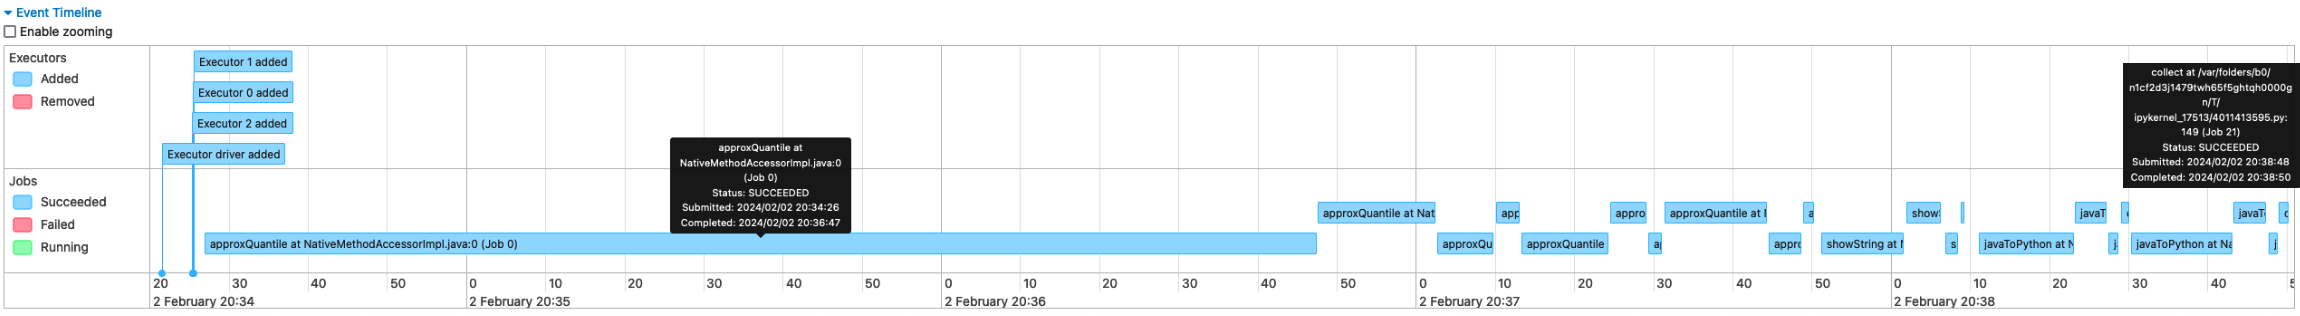

- Start time: 20:34:26
- End time: 20:38:50
- Total time: 4.3min

![Image](https://i.imgur.com/ZgFCvut.png)

![Image](https://i.imgur.com/26hlKdv.png)

You can observe through the Spark UI that there are
- Median Duration: 5s
- Median GC Time: 0.3
- Median Input Size / Records: 128.1/15959

### Test 10: initialize cluster with a memory of 1024MB on 3 Workers

In [ ]:
run_rfm_segmentation(master1024MB, bigData, schema)

![Image](https://i.imgur.com/dSbVpM5.png)

- Start time: 21:17:28
- End time: 21:22:14
- Total time: 4.4min

![Image](https://i.imgur.com/aE2BK25.png)

![Image](https://i.imgur.com/dD5NR6H.png)

You can observe through the Spark UI that there are
- Median Duration: 9s
- Median GC Time: 0.7s
- Median Input Size / Records: 128.1/15959

### Test 11: initialize cluster with a memory of 2048MB on 3 Workers

In [ ]:
#run_rfm_segmentation(master2048MB, bigData, schema)

![Image](https://i.imgur.com/Uj2DXk5.png)

- Start time: 21:07:28
- End time: 21:12:20
- Total time: 4.5 min

![Image](https://i.imgur.com/8BktzS2.png)

![Image](https://i.imgur.com/2NwhAla.png)

You can observe through the Spark UI that there are
- Median Duration: 9s
- Median GC Time: 0.7s
- Median Input Size / Records: 128.1/15959

### Test 12: initialize cluster with a memory of 4096MB on 3 Workers

In [ ]:
#run_rfm_segmentation(master4096B, bigData, schema)

![Image](https://i.imgur.com/G3507NJ.png)

- Start time: 21:26:07
- End time: 21:31:02
- Total time: 4.5min

![Image](https://i.imgur.com/gID55TZ.png)

![Image](https://i.imgur.com/EcoNVUo.png)

You can observe through the Spark UI that there are
- Median Duration: 9s
- Median GC Time: 0.7s
- Median Input Size / Records: 128.1/15959

**Conclusion Cluster Scalability**

| Test ID | Cores of Workers | Worker Nodes | RAM of Worker Node | Median Duration | Median GC Time | Median Input Size / Records | Application Time |
|---------|-------|--------------|--------------------|-----------------|----------------|-----------------------------|------------------|
| 4       | 10   | 1            | 15GiB                  | 6s              | 0.3s           | 128.1MiB / 15959            | 6.2min           |
| 5       | 10    | 2            | 15GiB                  | 7s              | 0.5s           | 128.1MiB / 15959            | 8.3min           |
| 6       | 10    | 3            | 15GiB                  | 10s             | 0.8s           | 128.1MiB / 15959            | 5.2min           |
| 7       | 10     | 6           | 15GiB                  | 1.4min          | 10s            | 128.1MiB / 15959            | 12.5min          |
| 8       | 2    | 10            | 15GiB                  | 3s              | 92ms           | 128.1MiB / 15959            | 6.1min           |
| 9       | 5    | 10            | 15GiB                  | 5s              | 0.3s           | 128.1MiB / 15959            | 4.3min           |
| 10      | 10     | 10            | 1024MiB                  | 9s              | 0.7s           | 128.1MiB / 15959            | 4.4min           |
| 11      | 10     | 10            | 20248MiB                  | 9s              | 0.7s           | 128.1MiB / 15959            | 4.5min           |
| 12      | 10     | 10            | 4096MiB                  | 9s              | 0.7s           | 128.1MiB / 15959            | 4.5min           |


This table provides insights into the scalability and performance of a local Spark standalone cluster under different configurations of worker node cores, the number of worker nodes, and RAM per worker node. By analyzing the data, we can observe several trends and implications for a local Spark standalone cluster performance:

- *Impact of Worker Nodes Quantity:* Increasing the number of worker nodes from 1 to 3 (Tests 4-6) does not uniformly decrease application time or median duration, suggesting that simply adding more nodes to the cluster does not linearly improve performance. This could be due to the overhead of managing more nodes or the nature of the tasks not fully benefiting from the additional nodes.

- *Resource Allocation vs. Performance:* Test 7, with 6 worker nodes, shows a significant increase in median duration and application time compared to tests with fewer nodes. This indicates that there might be a point of diminishing returns or even performance degradation when adding more nodes without adequately adjusting other parameters like the number of cores or RAM.

- *Variation in Cores per Worker:* Tests 8 and 9, with a higher number of worker nodes but fewer cores per worker (2 and 5 cores respectively), present a different performance profile, with Test 9 showing improved application time over Test 8. This suggests that the allocation of cores to tasks and their efficiency in processing could be more critical than the sheer number of nodes or cores.

- *RAM Impact:* Tests 10, 11, and 12, all with 10 worker nodes but varying RAM sizes (from 1024MiB to 20248MiB), demonstrate that increasing RAM does not directly correlate with improved performance in application time or median duration. Test 11, with the highest RAM, does not show a significant performance advantage over Tests 10 and 12. This outcome might highlight the importance of optimizing for the specific needs of the workload rather than assuming more RAM will always yield better performance.